Importing libraries...
✓ Libraries imported
Using device: cpu

Loading data...
✓ Train: 11 samples
✓ Val: 2 samples
✓ Test: 3 samples

Extracting audio features...
✓ Found 68 audio features

Data shapes:
  X_train: (11, 68)
  y_train: (11,)
✓ Features normalized
✓ Dataloaders created (batch_size=8)
✓ Model created

Model architecture:
AudioLSTM(
  (input_proj): Linear(in_features=68, out_features=128, bias=True)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 273,153
Trainable parameters: 273,153
✓ Training setup complete
  Loss: MSE
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau
✓ Training functions defined

TRAINING AUDIO-ONLY LSTM MODEL
Epoch 5/50
  Train Loss: 68.1045, MAE: 6.6369
  Val Loss: 12.0742, MAE: 2.5278, RMSE: 3.4748, R²: -0.9319
Epoch 10/50
  Train Loss: 58.3011, MAE: 6.4952
  Val Loss: 11.9156, MAE: 2.6063, RMSE: 3

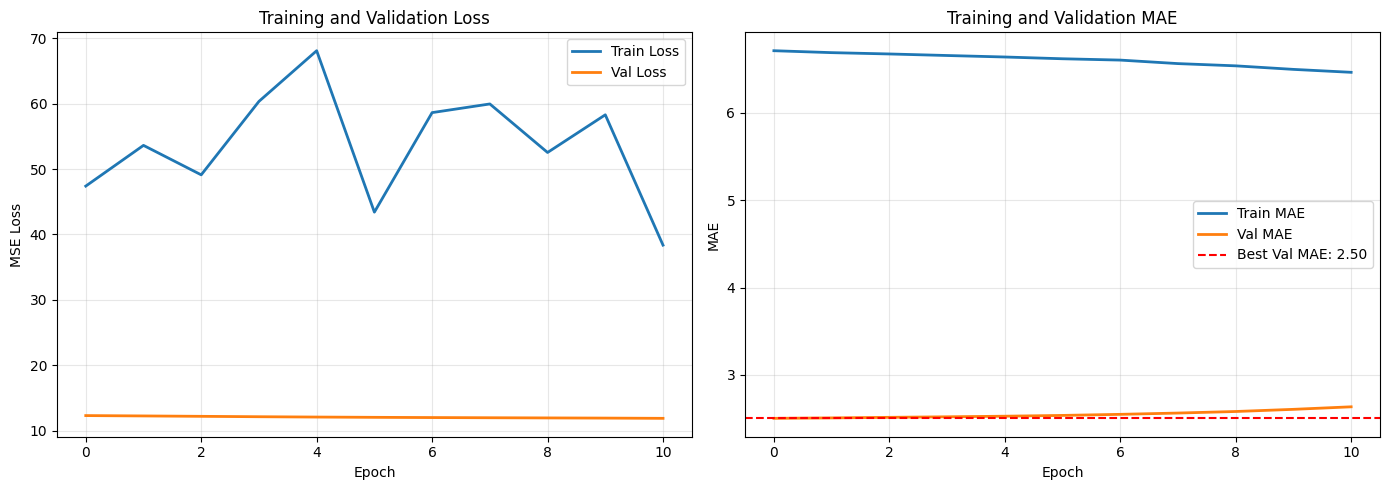


FINAL EVALUATION

📊 Validation Set Results:
  MAE: 2.5034
  RMSE: 3.5071
  R² Score: -0.9679

📊 Test Set Results:
  MAE: 9.9711
  RMSE: 12.4645
  R² Score: -1.7744


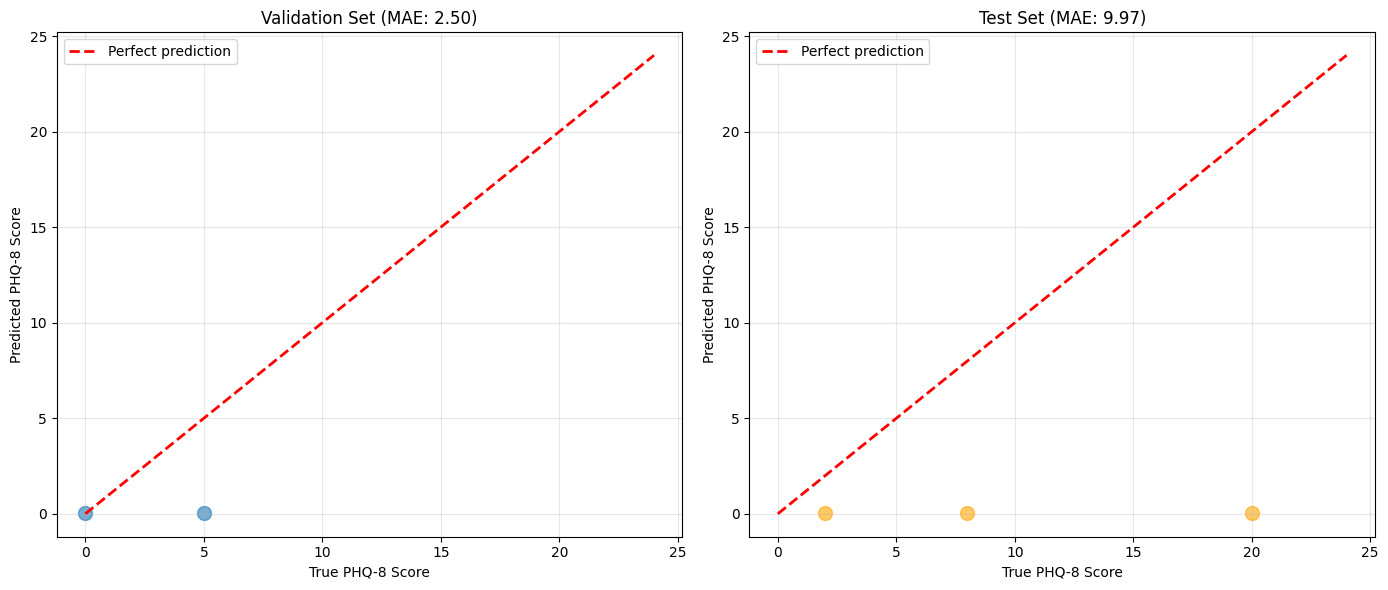


✅ AUDIO-ONLY LSTM BASELINE COMPLETE!

📊 Final Results:
  Validation MAE: 2.5034
  Test MAE: 9.9711
  Model saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models\audio_lstm_best.pth

🎯 Next: Run Notebook 7 for Text-only BERT baseline
✓ Saved metrics to C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\metrics\audio_lstm_results.csv


In [8]:
"""
NOTEBOOK 6: Audio-Only LSTM Baseline Model

SAVE AS: notebooks/modeling/01_audio_lstm_baseline.ipynb

WHAT THIS DOES:
- Builds LSTM model using ONLY audio features
- Trains for regression (predicting PHQ-8 score)
- Evaluates on validation set
- Saves model and results

TIME: ~10-20 minutes training
"""

# ========== CELL 1: Import Libraries ==========
print("Importing libraries...")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== CELL 2: Load Data ==========

print("\nLoading data...")

PROCESSED_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\data\processed')
MODELS_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Load splits
train_df = pd.read_csv(PROCESSED_DIR / 'train_data.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'val_data.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_data.csv')

print(f"✓ Train: {len(train_df)} samples")
print(f"✓ Val: {len(val_df)} samples")
print(f"✓ Test: {len(test_df)} samples")

# ========== CELL 3: Extract Audio Features Only ==========

print("\nExtracting audio features...")

# Get audio feature columns
audio_cols = [col for col in train_df.columns if any(x in col for x in 
              ['mfcc', 'pitch', 'energy', 'spectral', 'zcr', 'rolloff', 'duration'])]

print(f"✓ Found {len(audio_cols)} audio features")

# Prepare data
X_train = train_df[audio_cols].values
y_train = train_df['PHQ8_Score'].values

X_val = val_df[audio_cols].values
y_val = val_df['PHQ8_Score'].values

X_test = test_df[audio_cols].values
y_test = test_df['PHQ8_Score'].values

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

# Normalize features (important for neural networks!)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✓ Features normalized")

# ========== CELL 4: Create PyTorch Dataset ==========

class DepressionDataset(Dataset):
    """Dataset for depression detection"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DepressionDataset(X_train, y_train)
val_dataset = DepressionDataset(X_val, y_val)
test_dataset = DepressionDataset(X_test, y_test)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Dataloaders created (batch_size={batch_size})")

# ========== CELL 5: Define LSTM Model ==========

class AudioLSTM(nn.Module):
    """LSTM model for audio features"""
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(AudioLSTM, self).__init__()
        
        # Input projection (features → hidden size)
        self.input_proj = nn.Linear(input_size, hidden_size)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x shape: [batch_size, features]
        
        # Project input
        x = self.input_proj(x)  # [batch, hidden]
        
        # Add sequence dimension (LSTM expects 3D input)
        x = x.unsqueeze(1)  # [batch, 1, hidden]
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch, 1, hidden]
        
        # Take last output
        last_hidden = lstm_out[:, -1, :]  # [batch, hidden]
        
        # Dropout
        last_hidden = self.dropout(last_hidden)
        
        # Prediction
        output = self.fc(last_hidden)  # [batch, 1]
        
        return output.squeeze()  # [batch]

# Create model
input_size = X_train.shape[1]
model = AudioLSTM(input_size=input_size, hidden_size=128, num_layers=2)
model = model.to(device)

print(f"✓ Model created")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ========== CELL 6: Training Setup ==========

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("✓ Training setup complete")
print(f"  Loss: MSE")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau")

# ========== CELL 7: Training Function ==========

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    
    return avg_loss, mae

def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)
    
    return avg_loss, mae, rmse, r2, predictions, targets

print("✓ Training functions defined")

# ========== CELL 8: Train Model ==========

print("\n" + "="*60)
print("TRAINING AUDIO-ONLY LSTM MODEL")
print("="*60)

num_epochs = 50
best_val_mae = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    
    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), MODELS_DIR / 'audio_lstm_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n✓ Training complete!")
print(f"Best validation MAE: {best_val_mae:.4f}")

# ========== CELL 9: Plot Training History ==========

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(train_maes, label='Train MAE', linewidth=2)
axes[1].plot(val_maes, label='Val MAE', linewidth=2)
axes[1].axhline(y=best_val_mae, color='r', linestyle='--', label=f'Best Val MAE: {best_val_mae:.2f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR.parent.parent / 'results' / 'figures' / 'audio_lstm_training.png', dpi=300)
plt.show()

# ========== CELL 10: Final Evaluation ==========

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load(MODELS_DIR / 'audio_lstm_best.pth'))

# Evaluate on validation set
val_loss, val_mae, val_rmse, val_r2, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

print(f"\n📊 Validation Set Results:")
print(f"  MAE: {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R² Score: {val_r2:.4f}")

# Evaluate on test set
test_loss, test_mae, test_rmse, test_r2, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

print(f"\n📊 Test Set Results:")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R² Score: {test_r2:.4f}")

# ========== CELL 11: Visualize Predictions ==========

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Validation set
axes[0].scatter(val_targets, val_preds, alpha=0.6, s=100)
axes[0].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True PHQ-8 Score')
axes[0].set_ylabel('Predicted PHQ-8 Score')
axes[0].set_title(f'Validation Set (MAE: {val_mae:.2f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(test_targets, test_preds, alpha=0.6, s=100, color='orange')
axes[1].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('True PHQ-8 Score')
axes[1].set_ylabel('Predicted PHQ-8 Score')
axes[1].set_title(f'Test Set (MAE: {test_mae:.2f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR.parent.parent / 'results' / 'figures' / 'audio_lstm_predictions.png', dpi=300)
plt.show()

# ========== CELL 12: Summary ==========

print("\n" + "="*60)
print("✅ AUDIO-ONLY LSTM BASELINE COMPLETE!")
print("="*60)

print(f"\n📊 Final Results:")
print(f"  Validation MAE: {val_mae:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Model saved: {MODELS_DIR / 'audio_lstm_best.pth'}")

print(f"\n🎯 Next: Run Notebook 7 for Text-only BERT baseline")
print("="*60)


# ========== CELL 12A: Save Results ==========
RESULTS_DIR = MODELS_DIR.parent.parent / 'results' / 'metrics'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

results_dict = {
    'Model': ['Audio_LSTM'],
    'Val_MAE': [val_mae],
    'Val_RMSE': [val_rmse],
    'Val_R2': [val_r2],
    'Test_MAE': [test_mae],
    'Test_RMSE': [test_rmse],
    'Test_R2': [test_r2]
}

results_df = pd.DataFrame(results_dict)
results_df.to_csv(RESULTS_DIR / 'audio_lstm_results.csv', index=False)
print(f"✓ Saved metrics to {RESULTS_DIR / 'audio_lstm_results.csv'}")
